In [21]:
import nltk
import nlp
import cupy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from nltk.tokenize import word_tokenize
from nltk import ngrams
import random
dat = nlp.load_dataset('cnn_dailymail', '1.0.0')

In [2]:
n_articles = 200
n = 1

In [3]:
articles = dat['train']['article'][:n_articles]
tmp = [word_tokenize(article) for article in articles]
tmp = [item.lower() for sublist in tmp for item in sublist]
corpus = ' '.join(tmp)
text = list(ngrams(tmp, n))

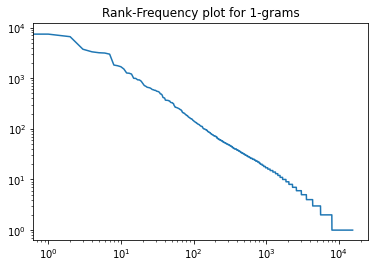

In [4]:
freqs_dict = Counter()
for tup in text:
    freqs_dict[tup] += 1
plt.plot([x[1] for x in freqs_dict.most_common()])
plt.yscale('log')
plt.xscale('log')
plt.title(f'Rank-Frequency plot for {n}-grams')
plt.show()

The Rank-Frequency plot follows Zipf's Law for all n-grams, assuming a reasonable n is chosen.

In [5]:
# freqs = np.array([x[1] for x in freqs_dict.most_common()])
# if len(freqs) % 2 == 0:
#     freqs = freqs[:-1] # if we have even number elements, remove least common one for convenience
# rel_freqs = freqs / sum(freqs)
# # rel_freqs = np.flip(rel_freqs)
# cdf_freqs = np.cumsum(rel_freqs)
# cdf_freqs = np.flip(cdf_freqs)
# centered = np.zeros(len(cdf_freqs))
# middle = int(len(cdf_freqs) / 2) - 1
# centered[middle] = cdf_freqs[0]
# for i in range(1, middle):
#     centered[middle + i] = cdf_freqs[i*2-1].item()
#     centered[middle - i] = cdf_freqs[i*2].item()
# mapped_cdf = [norm.ppf(val) for val in centered.get()]

In [6]:
# plt.subplot(3,1,1)
# plt.plot(cdf_freqs.get())
# plt.subplot(3,1,2)
# plt.plot(mapped_cdf)
# plt.subplot(3,1,3)
# plt.plot(centered.get())
# plt.show()

In [74]:
int_mapping = {}
order = list(range(len(freqs_dict)))
random.shuffle(order)
for i, (token, freq) in enumerate(freqs_dict.most_common()):
    int_mapping[token] = i            # set 0->most common token, 1->2nd most common...
    # int_mapping[token] = order[i]     # random order
    
reverse_int_mapping = {v:k for k,v in int_mapping.items()}

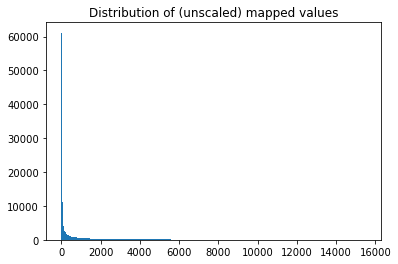

In [75]:
unscaled = np.asarray([int_mapping[tup] for tup in text])
plt.hist(unscaled.get(), bins=500)
plt.title('Distribution of (unscaled) mapped values')
plt.show()

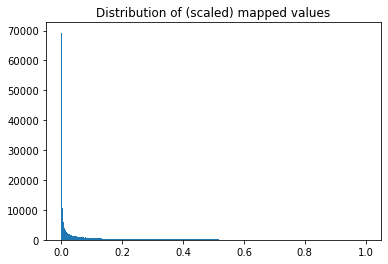

In [76]:
# logged = np.log(unscaled)
# scaled = (logged - logged.mean())/logged.std()
# scaled = (unscaled - unscaled.mean())/unscaled.std()
scaled = unscaled / unscaled.max()
# scaled = scaled - scaled.mean()
plt.hist(scaled.get(), bins=300)
plt.title('Distribution of (scaled) mapped values')
plt.show()

In [77]:
n_reservoir = 1000
n_inputs = 3
n_outputs = 1
n_layers = 1
density = .05
input_density = 1
leaky_rate = .1
connectivity = 'close'
scheme = 'uniform'
M = 50

In [78]:
if n_inputs > 1:
    x = []
    for i in range(len(scaled)-n_inputs+1):
        x.append(scaled[i:i+n_inputs])
else:
    x = scaled
x = np.asarray(x)

train_test_split = 0.7
num_train = round(len(x) * train_test_split)
train_x = x[:num_train]
test_x = x[num_train:]

In [83]:
def generate_weight_matrix(n_inputs, n_outputs, density, connectivity, scheme, M=0):
    n = n_inputs * n_outputs
    if connectivity == 'close':
        r = -1 + 2 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'larger':
        r = -5 + 10 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'smaller':
        r = -.5 + np.random.rand(n_inputs, n_outputs)
    else:
        sys.exit('Invalid connectivity parameter')

    if scheme == 'uniform':
        W = np.random.rand(n_inputs, n_outputs) < density
    elif scheme == 'erdos-renyi':
        if M == 0:
            M = np.random.randint(1, n)
        W = np.zeros((n_inputs, n_outputs))
        for i in range(M):
            not_done = True
            while not_done:
                i = np.random.randint(1, n_inputs)
                j = np.random.randint(1, n_outputs)
                if W[i,j] == 0:
                    W[i,j] = 1
                    not_done = False
    else:
        sys.exit('Invalid scheme parameter')

    return np.multiply(W, r)

class layer:        
    def __init__(self, n_reservoir, n_inputs, n_outputs, density, input_density, 
                 connectivity, scheme, is_first_layer=False, leaky_rate=None, M=0):
        # self.Win = (-.1 + .2*np.random.rand(n_inputs,n_reservoir)) * 1
        self.Win = .2*np.random.rand(n_inputs, n_reservoir)
        self.W = generate_weight_matrix(n_reservoir, n_reservoir, density, connectivity, scheme, M)
        scale = 1/self.W.max()
        self.W = self.W / scale

        self.x = np.expand_dims(np.zeros(n_reservoir), 1)
        self.a = leaky_rate
        self.D = []
            
    def update(self, u):
        recursive_influence = np.dot(self.W, self.x)
        if len(u.shape) == 1:
            inward_influence = np.dot(self.Win.T, np.expand_dims(u,1))
        else:
            inward_influence = np.dot(self.Win.T, u)
        if not self.a is None:
            recursive_influence = self.a * recursive_influence
            inward_influence = (1 - self.a) * inward_influence
            
        
        total_influence = recursive_influence + inward_influence
        # self.x = np.tanh(total_influence)
        self.x =  (total_influence > 0) * total_influence #+\
            # (total_influence < 0) * total_influence * 0.1

In [84]:
layers_save = []
for i_layer in range(n_layers):
    if i_layer == 0:
        layers_save.append(layer(n_reservoir, n_inputs, n_reservoir, density, input_density, connectivity, scheme, True, leaky_rate, M))
    elif i_layer == n_layers-1:
        layers_save.append(layer(n_reservoir, n_reservoir, n_outputs, density, input_density, connectivity, scheme, False, leaky_rate, M))
    else:
        layers_save.append(layer(n_reservoir, n_reservoir, n_reservoir, density, input_density, connectivity, scheme, False, leaky_rate, M))

#### Get internal states under training data

100% completed


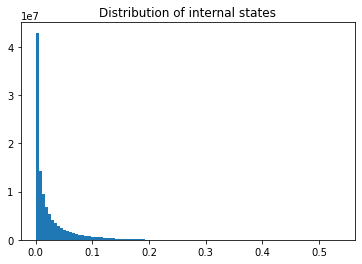

In [85]:
transient_factor = 0.1
layers = layers_save
transient = round(len(train_x) * transient_factor)

X = np.zeros((len(train_x), n_reservoir))
last = 0
for t in range(len(train_x)):
    u = train_x[t]
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    X[t] = np.squeeze(layers[n_layers-1].x)
    if t % 500 == 0:
        last = round(100*t/len(train_x))
        clear_output(wait=True)
        print(f'{last}% completed')
plt.hist(X.get().flatten(), bins=100)
plt.title('Distribution of internal states')
plt.show()

#### Train linear output layer

In [87]:
model = LinearRegression().fit(X[transient:-1].get(), train_x[transient+1:].get())
train_MSE = np.mean((model.predict(X[transient:-1].get()) - train_x[transient+1:].get())**2)
print(f'Training MSE = {train_MSE}')

Training MSE = 0.009510113490222771


#### Get internal states under testing data

100% completed


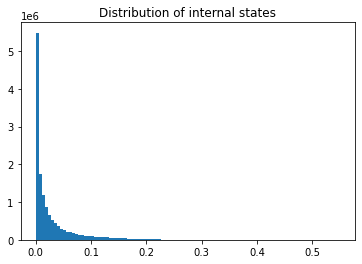

In [88]:
transient_factor = 0.7
predict = round(len(test_x) * (1 - transient_factor))

layers = layers_save

X = np.zeros((len(test_x[:predict]), n_reservoir))
last = 0
for t in range(len(test_x[:predict])):
    u = test_x[t]
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    X[t] = np.squeeze(layers[n_layers-1].x)
    if t % 100 == 0:
        last = round(100*t/len(test_x[:predict]))
        clear_output(wait=True)
        print(f'{last}% completed')
plt.hist(X.get().flatten(), bins=100)
plt.title('Distribution of internal states')
plt.show()

#### Begin feeding back in our predictions to generate new text

In [89]:
reverse_int_mapping_vals = np.asarray(list(reverse_int_mapping.keys()))
def value_to_word(val):
    idx = (np.abs(reverse_int_mapping_vals - val)).argmin().item()
    return reverse_int_mapping[list(reverse_int_mapping.keys())[idx]]

In [90]:
pred_X = np.zeros((len(test_x[-predict:]), n_reservoir))
u = np.array(model.predict(X[-1].get().reshape(1,-1))).reshape(-1,1)
generated_text = []
for t in range(len(test_x[-predict:])):
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    pred_X[t] = np.squeeze(layers[n_layers-1].x)
    u = np.array(model.predict(pred_X[t].get().reshape(1,-1))).reshape(-1,1)
    generated_text.append(value_to_word(u[0][0]))
    if t % 50 == 0:
        last = round(100*t/len(test_x[-predict:]))
        clear_output(wait=True)
        print(f'{last}% completed')
    if t==100:
        break
# plt.hist(pred_X.get().flatten(), bins=100)
# plt.title('Distribution of internal states')
# plt.show()
print(generated_text)

1% completed
[('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',), ('as',)]


In [91]:
int_mapping[('as',)]

0

### Discussion
As we somewhat expected, the model is no better at generating text than a simple probablistic model. Whatever token is assigned to **zero** is the most generated value, whether we use *tanh*, *ReLU*, or *leaky ReLU* activation function for the internal nodes.

### BERT embeddings
BERT outputs a 1x768 vector for each of up to 512 words in a sequence. Here I'm seeing how these vectors (picking one element) evolve over the 512 sequence.

In [26]:
from transformers import AutoModel, AutoTokenizer
model_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
berted = []
for i, article in enumerate(articles):
    tokenized = tokenizer(article, return_tensors='pt')
    if tokenized.input_ids.shape[1] > 512:
        berted.append(bert(tokenized.input_ids[0][:511].reshape(1,-1)).last_hidden_state)
    clear_output(wait=True)
    print(round(100*i/len(articles)))

100


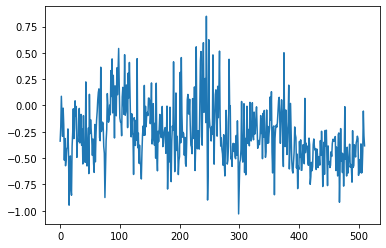

In [50]:
for i in range(len(berted)):
    plt.plot(berted[i].last_hidden_state

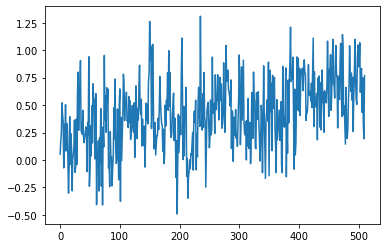

In [62]:
plt.plot(berted[1][0,:,4].detach().numpy())

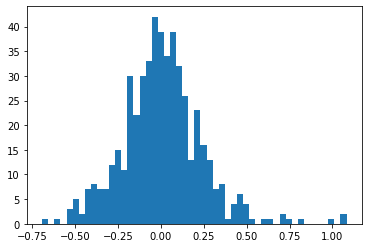

In [77]:
plt.hist(berted[6][0,:,3].detach().numpy(), bins=50)
plt.show()